# 4장. 분류
# Light GBM
#### : 한 쪽이 규칙이 없으면 다른 한 쪽만 판다. 그래서 Depth가 중요하지 않고, leaf node를 몇개까지 가지느냐가 중요. 
#### : 가장 큰 장점은 XGBoost보다 학습에 걸리는 시간이 훨씬 적으면서 예측 성능이 별다른 차이가 없다는 점.
#### : 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 사용. 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨. 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다.

## LightGBM의 XGBoost 대비 장점
+ 더 빠른 학습과 예측 수행 시간
+ 더 작은 메모리 사용량
+ 카테고리형 피처의 자동 변환과 최적분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

## LightGBM 하이퍼 파라미터
    주의할 점 : XGBoost와 다르게 리프 노드가 계속 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요하다는 점.
    num_leaves[default=31] : 하나의 트리가 가질 수 있는 최대 리프 개수. LightGBM에서 가장 중요한 파라미터. 

## 하이퍼 파라미터 튜닝 방안
    num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함꼐 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안.
+ num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터이다. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 보델 복잡도가 커져 과적합 영향도가 커짐.
+ min_data_in_leaf : 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀜. 과적합을 개선하기 위한 주요한 파라미터. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는것을 방지.
+ max_depth : 명시적으로 깊이의 크기를 제한함. 위의 두 파라미터와 결합해 과적합을 개선하는데 사용.
#### => learning_rate를 작게 하면서 n_estimators를 크게 하는 것이 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안.

## LightGBM 적용 - 위스콘신 유방암 예측

In [ ]:
# LightGBM의 파이썬 패키지인 lightGBM에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
ftr=dataset.data
target=dataset.target

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper=LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals=[(X_test, y_test)] # 원래는 학습데이터로 evals해서 validation 해야 함. 원래는 X_train, y_train으로.
                        # But, 평가할땐 GridSearchCV를 가장 많이 씀.
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True) # 학습시키기
preds=lgbm_wrapper.predict(X_test) # 예측

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred) # 오차행렬
    accuracy=accuracy_score(y_test, pred) # 정확도
    precision=precision_score(y_test, pred) # 정밀도
    recall=recall_score(y_test, pred) # 재현율
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [ ]:
get_clf_eval(y_test, preds)

In [ ]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

# 분류 실습 - 캐글 산탄데르 고객 만족 예측

## 데이터 전처리

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df=pd.read_csv("/Users/air/Leena Python/MachineLearning/Data/santander-customer-satisfaction/train.csv")
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
# Null값을 알아보자.
cust_df.info()

In [5]:
# NULL값이 없으니 전체 데이터에서 만족과 불만족의 비율을 살펴보기.
# TARGET의 1이 불만족, 0이 만족.
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
# DataFrame의 describe() 메서드를 이용해 각 피처의 값 분포 확인해보기.
cust_df.describe()

#### => var3의 min 값이 -999999임. var3 값을 조사해보면 -999999 값이 116개가 있음. -999999를 가장 값이 많은 2로 변환하자.

In [6]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
# 학습과 성능 평가를 위해 원본 데이터 세트에서 학습과 테스트를 분리. 비대칭한 데이터 세트이므로 클래스인 Target값 분포도가 
# 학습과 테스트에서 모두 비슷하게 추출되었는지 확인.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, 
                                                 test_size=0.2, random_state=0, 
                                                 stratify=y_labels)
train_cnt=y_train.count()
test_cnt=y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))
print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960438
1    0.039562
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.960405
1    0.039595
Name: TARGET, dtype: float64


#### => 학습과 테스트 데이터 세트 모두 TARGET의 값 분포가 원본 데이터와 유사하게 전체 데이터의 0.39%정도의 불만족 값(값 1)로 만들어졌다.

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf=XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
           eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])
            # eval_set은 원래 train데이터만 가지고 해야함.
xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.806131	validation_1-auc:0.778639
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.811867	validation_1-auc:0.784901
[2]	validation_0-auc:0.81454	validation_1-auc:0.788032
[3]	validation_0-auc:0.816373	validation_1-auc:0.790142
[4]	validation_0-auc:0.817591	validation_1-auc:0.791164
[5]	validation_0-auc:0.821018	validation_1-auc:0.794698
[6]	validation_0-auc:0.822843	validation_1-auc:0.796272
[7]	validation_0-auc:0.824045	validation_1-auc:0.796976
[8]	validation_0-auc:0.823207	validation_1-auc:0.796625
[9]	validation_0-auc:0.822984	validation_1-auc:0.796541
[10]	validation_0-auc:0.821323	validation_1-auc:0.795906
[11]	validation_0-auc:0.823286	validation_1-auc:0.796844
[12]	validation_0-auc:0.824967	validation_1-auc:0.79843
[13]	validation_0-auc:0.823987	validation_1-auc:0.797144
[14]	validation_0-auc:0.825334	validation_1-auc:0.798617

[141]	validation_0-auc:0.865204	validation_1-auc:0.824012
[142]	validation_0-auc:0.865296	validation_1-auc:0.824098
[143]	validation_0-auc:0.865413	validation_1-auc:0.824031
[144]	validation_0-auc:0.865482	validation_1-auc:0.824067
[145]	validation_0-auc:0.865664	validation_1-auc:0.823951
[146]	validation_0-auc:0.865727	validation_1-auc:0.823939
[147]	validation_0-auc:0.865977	validation_1-auc:0.823965
[148]	validation_0-auc:0.86606	validation_1-auc:0.823847
[149]	validation_0-auc:0.866117	validation_1-auc:0.823899
[150]	validation_0-auc:0.866148	validation_1-auc:0.823896
[151]	validation_0-auc:0.866232	validation_1-auc:0.823841
[152]	validation_0-auc:0.866293	validation_1-auc:0.823723
[153]	validation_0-auc:0.866364	validation_1-auc:0.823744
[154]	validation_0-auc:0.866578	validation_1-auc:0.823682
[155]	validation_0-auc:0.8667	validation_1-auc:0.823632
[156]	validation_0-auc:0.866765	validation_1-auc:0.823568
[157]	validation_0-auc:0.866973	validation_1-auc:0.823512
[158]	validation_

#### => XGBoost의 하이퍼 파라미터 튜닝을 해보자. 칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝 대상으로 하자.

#### 요령 : 먼저 2 ~ 3개 정도의 파라미터를 결합해 최적 파라미터를 찾아낸 뒤에 이 최적 파라미터를 기반으로 다시 1~2개 파라미터를 결합해 파라미터 튜닝 수행.

In [2]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf=XGBClassifier(n_estimators=500)

params={'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}

gridcv=GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc",
          eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score=roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))


NameError: name 'XGBClassifier' is not defined

In [ ]:
# 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내보기.
from xboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [6]:
#### => XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [10]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf=LGBMClassifier(n_estimators=500)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
            verbose=True)
    # eval_set : early_stopping_rounds를 쓰기 위해 꼭 써줘야 하는 파라미터. 교차검증을 수행할 테스트를 써줌.
    # eval_metrics : 평가할 기준
lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.795963	valid_0's binary_logloss: 0.159288
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.801791	valid_0's binary_logloss: 0.155033
[3]	valid_0's auc: 0.803347	valid_0's binary_logloss: 0.151848
[4]	valid_0's auc: 0.804643	valid_0's binary_logloss: 0.14969
[5]	valid_0's auc: 0.808337	valid_0's binary_logloss: 0.14774
[6]	valid_0's auc: 0.810543	valid_0's binary_logloss: 0.146248
[7]	valid_0's auc: 0.815338	valid_0's binary_logloss: 0.144947
[8]	valid_0's auc: 0.816354	valid_0's binary_logloss: 0.143927
[9]	valid_0's auc: 0.817909	valid_0's binary_logloss: 0.143015
[10]	valid_0's auc: 0.818505	valid_0's binary_logloss: 0.142346
[11]	valid_0's auc: 0.818062	valid_0's binary_logloss: 0.14179
[12]	valid_0's auc: 0.819618	valid_0's binary_logloss: 0.141273
[13]	valid_0's auc: 0.820168	valid_0's binary_logloss: 0.140783
[14]	valid_0's auc: 0.821643	valid_0's binary_logloss: 0.140372
[15]	valid_0's auc: 0.821538	valid_0's binary_logloss:

[130]	valid_0's auc: 0.812864	valid_0's binary_logloss: 0.141747
Early stopping, best iteration is:
[30]	valid_0's auc: 0.823853	valid_0's binary_logloss: 0.138211
ROC AUC: 0.8239


In [11]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
LGBM_clf=LGBMClassifier(n_estimators=200)

params={'num_leaves': [32,64],
       'max_depth': [128,160],
       'min_child_samples':[60,100],
       'subsample':[0.8,1]}

# 하이퍼 파라미터 테스트의 수행속도를 향상시키기 위해 cv를 지정하지 않는다.
gridcv=GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
          eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score=roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

/Users/air/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's auc: 0.823013	valid_0's binary_logloss: 0.157599	valid_1's auc: 0.790743	valid_1's binary_logloss: 0.15957
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.829507	valid_0's binary_logloss: 0.15203	valid_1's auc: 0.79822	valid_1's binary_logloss: 0.154927
[3]	valid_0's auc: 0.834674	valid_0's binary_logloss: 0.147974	valid_1's auc: 0.800682	valid_1's binary_logloss: 0.1519
[4]	valid_0's auc: 0.841586	valid_0's binary_logloss: 0.144944	valid_1's auc: 0.806748	valid_1's binary_logloss: 0.149617
[5]	valid_0's auc: 0.845466	valid_0's binary_logloss: 0.142464	valid_1's auc: 0.812166	valid_1's binary_logloss: 0.147629
[6]	valid_0's auc: 0.846831	valid_0's binary_logloss: 0.140356	valid_1's auc: 0.812302	valid_1's binary_logloss: 0.146166
[7]	valid_0's auc: 0.848919	valid_0's binary_logloss: 0.138617	valid_1's auc: 0.813475	valid_1's binary_logloss: 0.144915
[8]	valid_0's auc: 0.850955	valid_0's binary_logloss: 0.137114	valid_1's auc: 0.814566	val

[18]	valid_0's auc: 0.867129	valid_0's binary_logloss: 0.128596	valid_1's auc: 0.819342	valid_1's binary_logloss: 0.139283
[19]	valid_0's auc: 0.867988	valid_0's binary_logloss: 0.128093	valid_1's auc: 0.818945	valid_1's binary_logloss: 0.139217
[20]	valid_0's auc: 0.869463	valid_0's binary_logloss: 0.127658	valid_1's auc: 0.820062	valid_1's binary_logloss: 0.139041
[21]	valid_0's auc: 0.870407	valid_0's binary_logloss: 0.127196	valid_1's auc: 0.820255	valid_1's binary_logloss: 0.138914
[22]	valid_0's auc: 0.871522	valid_0's binary_logloss: 0.126731	valid_1's auc: 0.819604	valid_1's binary_logloss: 0.138934
[23]	valid_0's auc: 0.872375	valid_0's binary_logloss: 0.126352	valid_1's auc: 0.820358	valid_1's binary_logloss: 0.1388
[24]	valid_0's auc: 0.873258	valid_0's binary_logloss: 0.125964	valid_1's auc: 0.820444	valid_1's binary_logloss: 0.138744
[25]	valid_0's auc: 0.873962	valid_0's binary_logloss: 0.12561	valid_1's auc: 0.820434	valid_1's binary_logloss: 0.138744
[26]	valid_0's auc:

[18]	valid_0's auc: 0.865267	valid_0's binary_logloss: 0.128956	valid_1's auc: 0.817738	valid_1's binary_logloss: 0.139761
[19]	valid_0's auc: 0.866858	valid_0's binary_logloss: 0.12844	valid_1's auc: 0.818158	valid_1's binary_logloss: 0.139633
[20]	valid_0's auc: 0.868196	valid_0's binary_logloss: 0.127954	valid_1's auc: 0.818025	valid_1's binary_logloss: 0.139504
[21]	valid_0's auc: 0.868978	valid_0's binary_logloss: 0.127545	valid_1's auc: 0.817732	valid_1's binary_logloss: 0.139462
[22]	valid_0's auc: 0.869659	valid_0's binary_logloss: 0.127168	valid_1's auc: 0.818141	valid_1's binary_logloss: 0.139343
[23]	valid_0's auc: 0.870605	valid_0's binary_logloss: 0.126766	valid_1's auc: 0.818161	valid_1's binary_logloss: 0.139218
[24]	valid_0's auc: 0.871415	valid_0's binary_logloss: 0.126406	valid_1's auc: 0.81862	valid_1's binary_logloss: 0.139084
[25]	valid_0's auc: 0.872273	valid_0's binary_logloss: 0.126071	valid_1's auc: 0.818344	valid_1's binary_logloss: 0.139011
[26]	valid_0's auc

[33]	valid_0's auc: 0.878638	valid_0's binary_logloss: 0.123732	valid_1's auc: 0.819364	valid_1's binary_logloss: 0.139115
[34]	valid_0's auc: 0.879627	valid_0's binary_logloss: 0.123421	valid_1's auc: 0.819257	valid_1's binary_logloss: 0.13914
[35]	valid_0's auc: 0.880346	valid_0's binary_logloss: 0.123149	valid_1's auc: 0.819089	valid_1's binary_logloss: 0.139139
[36]	valid_0's auc: 0.881101	valid_0's binary_logloss: 0.122889	valid_1's auc: 0.819733	valid_1's binary_logloss: 0.139053
[37]	valid_0's auc: 0.881497	valid_0's binary_logloss: 0.122683	valid_1's auc: 0.819653	valid_1's binary_logloss: 0.139028
[38]	valid_0's auc: 0.882174	valid_0's binary_logloss: 0.122419	valid_1's auc: 0.820062	valid_1's binary_logloss: 0.138994
[39]	valid_0's auc: 0.882808	valid_0's binary_logloss: 0.122181	valid_1's auc: 0.82003	valid_1's binary_logloss: 0.139009
[40]	valid_0's auc: 0.883533	valid_0's binary_logloss: 0.121972	valid_1's auc: 0.819923	valid_1's binary_logloss: 0.139049
[41]	valid_0's auc

[50]	valid_0's auc: 0.889422	valid_0's binary_logloss: 0.11968	valid_1's auc: 0.820719	valid_1's binary_logloss: 0.13893
[51]	valid_0's auc: 0.889733	valid_0's binary_logloss: 0.119511	valid_1's auc: 0.820275	valid_1's binary_logloss: 0.139023
[52]	valid_0's auc: 0.890045	valid_0's binary_logloss: 0.11937	valid_1's auc: 0.82049	valid_1's binary_logloss: 0.139025
[53]	valid_0's auc: 0.89034	valid_0's binary_logloss: 0.119232	valid_1's auc: 0.821015	valid_1's binary_logloss: 0.138946
[54]	valid_0's auc: 0.890696	valid_0's binary_logloss: 0.119081	valid_1's auc: 0.820884	valid_1's binary_logloss: 0.138961
[55]	valid_0's auc: 0.890974	valid_0's binary_logloss: 0.118926	valid_1's auc: 0.820359	valid_1's binary_logloss: 0.139108
[56]	valid_0's auc: 0.891205	valid_0's binary_logloss: 0.118783	valid_1's auc: 0.820047	valid_1's binary_logloss: 0.139203
[57]	valid_0's auc: 0.891381	valid_0's binary_logloss: 0.118666	valid_1's auc: 0.820092	valid_1's binary_logloss: 0.139228
[58]	valid_0's auc: 0

[51]	valid_0's auc: 0.88819	valid_0's binary_logloss: 0.119813	valid_1's auc: 0.815391	valid_1's binary_logloss: 0.13983
[52]	valid_0's auc: 0.888372	valid_0's binary_logloss: 0.119687	valid_1's auc: 0.81536	valid_1's binary_logloss: 0.139903
[53]	valid_0's auc: 0.888896	valid_0's binary_logloss: 0.119475	valid_1's auc: 0.815393	valid_1's binary_logloss: 0.139942
[54]	valid_0's auc: 0.889142	valid_0's binary_logloss: 0.119352	valid_1's auc: 0.815067	valid_1's binary_logloss: 0.140009
[55]	valid_0's auc: 0.889463	valid_0's binary_logloss: 0.119195	valid_1's auc: 0.814991	valid_1's binary_logloss: 0.140061
[56]	valid_0's auc: 0.890229	valid_0's binary_logloss: 0.118978	valid_1's auc: 0.815225	valid_1's binary_logloss: 0.140066
Early stopping, best iteration is:
[26]	valid_0's auc: 0.873415	valid_0's binary_logloss: 0.125678	valid_1's auc: 0.819129	valid_1's binary_logloss: 0.138913
[1]	valid_0's auc: 0.831433	valid_0's binary_logloss: 0.156791	valid_1's auc: 0.79396	valid_1's binary_logl

[8]	valid_0's auc: 0.864208	valid_0's binary_logloss: 0.134519	valid_1's auc: 0.817062	valid_1's binary_logloss: 0.142938
[9]	valid_0's auc: 0.865795	valid_0's binary_logloss: 0.133023	valid_1's auc: 0.81612	valid_1's binary_logloss: 0.142232
[10]	valid_0's auc: 0.866954	valid_0's binary_logloss: 0.131736	valid_1's auc: 0.816593	valid_1's binary_logloss: 0.141556
[11]	valid_0's auc: 0.868938	valid_0's binary_logloss: 0.130572	valid_1's auc: 0.817722	valid_1's binary_logloss: 0.140987
[12]	valid_0's auc: 0.871734	valid_0's binary_logloss: 0.129516	valid_1's auc: 0.819121	valid_1's binary_logloss: 0.140435
[13]	valid_0's auc: 0.872879	valid_0's binary_logloss: 0.1286	valid_1's auc: 0.818719	valid_1's binary_logloss: 0.140105
[14]	valid_0's auc: 0.874233	valid_0's binary_logloss: 0.127679	valid_1's auc: 0.818968	valid_1's binary_logloss: 0.139829
[15]	valid_0's auc: 0.875363	valid_0's binary_logloss: 0.126883	valid_1's auc: 0.819191	valid_1's binary_logloss: 0.139543
[16]	valid_0's auc: 0

[16]	valid_0's auc: 0.876757	valid_0's binary_logloss: 0.126089	valid_1's auc: 0.817564	valid_1's binary_logloss: 0.139949
[17]	valid_0's auc: 0.878171	valid_0's binary_logloss: 0.12539	valid_1's auc: 0.818052	valid_1's binary_logloss: 0.139735
[18]	valid_0's auc: 0.879391	valid_0's binary_logloss: 0.12469	valid_1's auc: 0.817638	valid_1's binary_logloss: 0.139691
[19]	valid_0's auc: 0.880911	valid_0's binary_logloss: 0.12406	valid_1's auc: 0.817184	valid_1's binary_logloss: 0.13966
[20]	valid_0's auc: 0.882094	valid_0's binary_logloss: 0.12346	valid_1's auc: 0.816434	valid_1's binary_logloss: 0.139619
[21]	valid_0's auc: 0.883198	valid_0's binary_logloss: 0.122872	valid_1's auc: 0.816936	valid_1's binary_logloss: 0.139537
[22]	valid_0's auc: 0.884226	valid_0's binary_logloss: 0.122327	valid_1's auc: 0.816629	valid_1's binary_logloss: 0.139568
[23]	valid_0's auc: 0.885491	valid_0's binary_logloss: 0.121776	valid_1's auc: 0.81733	valid_1's binary_logloss: 0.139548
[24]	valid_0's auc: 0.

[42]	valid_0's auc: 0.902381	valid_0's binary_logloss: 0.114007	valid_1's auc: 0.820176	valid_1's binary_logloss: 0.139347
[43]	valid_0's auc: 0.902864	valid_0's binary_logloss: 0.113687	valid_1's auc: 0.819558	valid_1's binary_logloss: 0.139491
[44]	valid_0's auc: 0.903229	valid_0's binary_logloss: 0.113394	valid_1's auc: 0.819096	valid_1's binary_logloss: 0.139583
[45]	valid_0's auc: 0.903454	valid_0's binary_logloss: 0.113151	valid_1's auc: 0.81858	valid_1's binary_logloss: 0.139682
[46]	valid_0's auc: 0.904066	valid_0's binary_logloss: 0.112885	valid_1's auc: 0.818207	valid_1's binary_logloss: 0.139792
[47]	valid_0's auc: 0.904962	valid_0's binary_logloss: 0.112592	valid_1's auc: 0.818366	valid_1's binary_logloss: 0.139823
[48]	valid_0's auc: 0.905501	valid_0's binary_logloss: 0.112306	valid_1's auc: 0.817769	valid_1's binary_logloss: 0.139977
[49]	valid_0's auc: 0.905716	valid_0's binary_logloss: 0.112067	valid_1's auc: 0.817231	valid_1's binary_logloss: 0.140093
[50]	valid_0's au

[58]	valid_0's auc: 0.905521	valid_0's binary_logloss: 0.111001	valid_1's auc: 0.818704	valid_1's binary_logloss: 0.140193
[59]	valid_0's auc: 0.905676	valid_0's binary_logloss: 0.110836	valid_1's auc: 0.818176	valid_1's binary_logloss: 0.140377
Early stopping, best iteration is:
[29]	valid_0's auc: 0.890437	valid_0's binary_logloss: 0.119227	valid_1's auc: 0.821477	valid_1's binary_logloss: 0.138476
[1]	valid_0's auc: 0.837304	valid_0's binary_logloss: 0.156868	valid_1's auc: 0.801659	valid_1's binary_logloss: 0.159052
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.845141	valid_0's binary_logloss: 0.150918	valid_1's auc: 0.80983	valid_1's binary_logloss: 0.154357
[3]	valid_0's auc: 0.851912	valid_0's binary_logloss: 0.146575	valid_1's auc: 0.808881	valid_1's binary_logloss: 0.151322
[4]	valid_0's auc: 0.854813	valid_0's binary_logloss: 0.143273	valid_1's auc: 0.808675	valid_1's binary_logloss: 0.148954
[5]	valid_0's auc: 0.858608	valid_0's binary_log

[24]	valid_0's auc: 0.869315	valid_0's binary_logloss: 0.12729	valid_1's auc: 0.821328	valid_1's binary_logloss: 0.138954
[25]	valid_0's auc: 0.870441	valid_0's binary_logloss: 0.12694	valid_1's auc: 0.820993	valid_1's binary_logloss: 0.138981
[26]	valid_0's auc: 0.871536	valid_0's binary_logloss: 0.126577	valid_1's auc: 0.820877	valid_1's binary_logloss: 0.138992
[27]	valid_0's auc: 0.872334	valid_0's binary_logloss: 0.12626	valid_1's auc: 0.82073	valid_1's binary_logloss: 0.138989
[28]	valid_0's auc: 0.872925	valid_0's binary_logloss: 0.125986	valid_1's auc: 0.820649	valid_1's binary_logloss: 0.138943
[29]	valid_0's auc: 0.873692	valid_0's binary_logloss: 0.125691	valid_1's auc: 0.820447	valid_1's binary_logloss: 0.138939
[30]	valid_0's auc: 0.874318	valid_0's binary_logloss: 0.125448	valid_1's auc: 0.820525	valid_1's binary_logloss: 0.138938
[31]	valid_0's auc: 0.875133	valid_0's binary_logloss: 0.125139	valid_1's auc: 0.820491	valid_1's binary_logloss: 0.13894
[32]	valid_0's auc: 0

[38]	valid_0's auc: 0.87977	valid_0's binary_logloss: 0.123345	valid_1's auc: 0.823807	valid_1's binary_logloss: 0.137792
[39]	valid_0's auc: 0.880471	valid_0's binary_logloss: 0.123102	valid_1's auc: 0.823786	valid_1's binary_logloss: 0.137843
[40]	valid_0's auc: 0.881523	valid_0's binary_logloss: 0.12287	valid_1's auc: 0.823973	valid_1's binary_logloss: 0.137795
[41]	valid_0's auc: 0.882095	valid_0's binary_logloss: 0.122653	valid_1's auc: 0.823512	valid_1's binary_logloss: 0.137876
[42]	valid_0's auc: 0.882813	valid_0's binary_logloss: 0.122416	valid_1's auc: 0.823326	valid_1's binary_logloss: 0.137931
[43]	valid_0's auc: 0.883262	valid_0's binary_logloss: 0.122214	valid_1's auc: 0.823153	valid_1's binary_logloss: 0.137962
[44]	valid_0's auc: 0.883734	valid_0's binary_logloss: 0.122018	valid_1's auc: 0.82273	valid_1's binary_logloss: 0.138029
[45]	valid_0's auc: 0.884287	valid_0's binary_logloss: 0.121807	valid_1's auc: 0.822415	valid_1's binary_logloss: 0.138118
[46]	valid_0's auc:

[52]	valid_0's auc: 0.885842	valid_0's binary_logloss: 0.120874	valid_1's auc: 0.82031	valid_1's binary_logloss: 0.138565
[53]	valid_0's auc: 0.886399	valid_0's binary_logloss: 0.120685	valid_1's auc: 0.820231	valid_1's binary_logloss: 0.138556
[54]	valid_0's auc: 0.88663	valid_0's binary_logloss: 0.120535	valid_1's auc: 0.819988	valid_1's binary_logloss: 0.138598
[55]	valid_0's auc: 0.886943	valid_0's binary_logloss: 0.120373	valid_1's auc: 0.81976	valid_1's binary_logloss: 0.138692
[56]	valid_0's auc: 0.887262	valid_0's binary_logloss: 0.120199	valid_1's auc: 0.819587	valid_1's binary_logloss: 0.138766
[57]	valid_0's auc: 0.887678	valid_0's binary_logloss: 0.120038	valid_1's auc: 0.819119	valid_1's binary_logloss: 0.138902
[58]	valid_0's auc: 0.887971	valid_0's binary_logloss: 0.119904	valid_1's auc: 0.818867	valid_1's binary_logloss: 0.138968
[59]	valid_0's auc: 0.888113	valid_0's binary_logloss: 0.119774	valid_1's auc: 0.819063	valid_1's binary_logloss: 0.138941
[60]	valid_0's auc:

[1]	valid_0's auc: 0.826898	valid_0's binary_logloss: 0.157392	valid_1's auc: 0.793104	valid_1's binary_logloss: 0.159146
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.837016	valid_0's binary_logloss: 0.151987	valid_1's auc: 0.802925	valid_1's binary_logloss: 0.154697
[3]	valid_0's auc: 0.841542	valid_0's binary_logloss: 0.148144	valid_1's auc: 0.807993	valid_1's binary_logloss: 0.151604
[4]	valid_0's auc: 0.843777	valid_0's binary_logloss: 0.145169	valid_1's auc: 0.810853	valid_1's binary_logloss: 0.149183
[5]	valid_0's auc: 0.847713	valid_0's binary_logloss: 0.142682	valid_1's auc: 0.813153	valid_1's binary_logloss: 0.147177
[6]	valid_0's auc: 0.850293	valid_0's binary_logloss: 0.140599	valid_1's auc: 0.817025	valid_1's binary_logloss: 0.145458
[7]	valid_0's auc: 0.851273	valid_0's binary_logloss: 0.138886	valid_1's auc: 0.818542	valid_1's binary_logloss: 0.144097
[8]	valid_0's auc: 0.852319	valid_0's binary_logloss: 0.137392	valid_1's auc: 0.81935

[19]	valid_0's auc: 0.863969	valid_0's binary_logloss: 0.129311	valid_1's auc: 0.820825	valid_1's binary_logloss: 0.138751
[20]	valid_0's auc: 0.865146	valid_0's binary_logloss: 0.128853	valid_1's auc: 0.821441	valid_1's binary_logloss: 0.138546
[21]	valid_0's auc: 0.866438	valid_0's binary_logloss: 0.128437	valid_1's auc: 0.821567	valid_1's binary_logloss: 0.138441
[22]	valid_0's auc: 0.867546	valid_0's binary_logloss: 0.127996	valid_1's auc: 0.821562	valid_1's binary_logloss: 0.138353
[23]	valid_0's auc: 0.868228	valid_0's binary_logloss: 0.127659	valid_1's auc: 0.822074	valid_1's binary_logloss: 0.138276
[24]	valid_0's auc: 0.869025	valid_0's binary_logloss: 0.127317	valid_1's auc: 0.821825	valid_1's binary_logloss: 0.138238
[25]	valid_0's auc: 0.869884	valid_0's binary_logloss: 0.126972	valid_1's auc: 0.821588	valid_1's binary_logloss: 0.138238
[26]	valid_0's auc: 0.87073	valid_0's binary_logloss: 0.126634	valid_1's auc: 0.821771	valid_1's binary_logloss: 0.138169
[27]	valid_0's au

[21]	valid_0's auc: 0.879888	valid_0's binary_logloss: 0.124398	valid_1's auc: 0.820526	valid_1's binary_logloss: 0.139051
[22]	valid_0's auc: 0.880992	valid_0's binary_logloss: 0.123865	valid_1's auc: 0.820188	valid_1's binary_logloss: 0.138977
[23]	valid_0's auc: 0.882103	valid_0's binary_logloss: 0.123372	valid_1's auc: 0.82024	valid_1's binary_logloss: 0.138887
[24]	valid_0's auc: 0.883067	valid_0's binary_logloss: 0.12292	valid_1's auc: 0.820013	valid_1's binary_logloss: 0.138904
[25]	valid_0's auc: 0.884125	valid_0's binary_logloss: 0.122466	valid_1's auc: 0.820277	valid_1's binary_logloss: 0.138868
[26]	valid_0's auc: 0.885436	valid_0's binary_logloss: 0.121953	valid_1's auc: 0.820298	valid_1's binary_logloss: 0.138831
[27]	valid_0's auc: 0.886786	valid_0's binary_logloss: 0.121465	valid_1's auc: 0.820098	valid_1's binary_logloss: 0.13889
[28]	valid_0's auc: 0.887947	valid_0's binary_logloss: 0.121012	valid_1's auc: 0.820285	valid_1's binary_logloss: 0.138895
[29]	valid_0's auc:

[27]	valid_0's auc: 0.886893	valid_0's binary_logloss: 0.121423	valid_1's auc: 0.823524	valid_1's binary_logloss: 0.137901
[28]	valid_0's auc: 0.887958	valid_0's binary_logloss: 0.120985	valid_1's auc: 0.824045	valid_1's binary_logloss: 0.137859
[29]	valid_0's auc: 0.88871	valid_0's binary_logloss: 0.120602	valid_1's auc: 0.823394	valid_1's binary_logloss: 0.137958
[30]	valid_0's auc: 0.889447	valid_0's binary_logloss: 0.120204	valid_1's auc: 0.822419	valid_1's binary_logloss: 0.138126
[31]	valid_0's auc: 0.890175	valid_0's binary_logloss: 0.119833	valid_1's auc: 0.82219	valid_1's binary_logloss: 0.13821
[32]	valid_0's auc: 0.89094	valid_0's binary_logloss: 0.119471	valid_1's auc: 0.822561	valid_1's binary_logloss: 0.138185
[33]	valid_0's auc: 0.891649	valid_0's binary_logloss: 0.119114	valid_1's auc: 0.822737	valid_1's binary_logloss: 0.138195
[34]	valid_0's auc: 0.892351	valid_0's binary_logloss: 0.118798	valid_1's auc: 0.82305	valid_1's binary_logloss: 0.138221
[35]	valid_0's auc: 0

[41]	valid_0's auc: 0.896956	valid_0's binary_logloss: 0.116574	valid_1's auc: 0.813041	valid_1's binary_logloss: 0.140396
[42]	valid_0's auc: 0.897664	valid_0's binary_logloss: 0.116218	valid_1's auc: 0.812965	valid_1's binary_logloss: 0.140485
[43]	valid_0's auc: 0.898295	valid_0's binary_logloss: 0.115905	valid_1's auc: 0.812361	valid_1's binary_logloss: 0.140644
[44]	valid_0's auc: 0.899018	valid_0's binary_logloss: 0.115618	valid_1's auc: 0.8124	valid_1's binary_logloss: 0.140655
Early stopping, best iteration is:
[14]	valid_0's auc: 0.870965	valid_0's binary_logloss: 0.129048	valid_1's auc: 0.817277	valid_1's binary_logloss: 0.140387
[1]	valid_0's auc: 0.83413	valid_0's binary_logloss: 0.157103	valid_1's auc: 0.791002	valid_1's binary_logloss: 0.159284
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841248	valid_0's binary_logloss: 0.151267	valid_1's auc: 0.801528	valid_1's binary_logloss: 0.154678
[3]	valid_0's auc: 0.849483	valid_0's binary_log

[1]	valid_0's auc: 0.835599	valid_0's binary_logloss: 0.156828	valid_1's auc: 0.794009	valid_1's binary_logloss: 0.158961
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.844679	valid_0's binary_logloss: 0.151106	valid_1's auc: 0.800884	valid_1's binary_logloss: 0.154501
[3]	valid_0's auc: 0.850355	valid_0's binary_logloss: 0.146966	valid_1's auc: 0.805962	valid_1's binary_logloss: 0.151429
[4]	valid_0's auc: 0.854061	valid_0's binary_logloss: 0.143781	valid_1's auc: 0.808405	valid_1's binary_logloss: 0.148943
[5]	valid_0's auc: 0.857803	valid_0's binary_logloss: 0.141209	valid_1's auc: 0.811798	valid_1's binary_logloss: 0.147036
[6]	valid_0's auc: 0.862405	valid_0's binary_logloss: 0.138865	valid_1's auc: 0.813969	valid_1's binary_logloss: 0.145318
[7]	valid_0's auc: 0.863826	valid_0's binary_logloss: 0.136992	valid_1's auc: 0.816857	valid_1's binary_logloss: 0.143972
[8]	valid_0's auc: 0.865406	valid_0's binary_logloss: 0.135358	valid_1's auc: 0.81869

[15]	valid_0's auc: 0.872318	valid_0's binary_logloss: 0.128304	valid_1's auc: 0.81724	valid_1's binary_logloss: 0.140192
[16]	valid_0's auc: 0.873925	valid_0's binary_logloss: 0.127605	valid_1's auc: 0.815679	valid_1's binary_logloss: 0.140061
[17]	valid_0's auc: 0.875064	valid_0's binary_logloss: 0.126889	valid_1's auc: 0.814656	valid_1's binary_logloss: 0.140003
[18]	valid_0's auc: 0.876484	valid_0's binary_logloss: 0.126249	valid_1's auc: 0.815305	valid_1's binary_logloss: 0.139817
[19]	valid_0's auc: 0.87793	valid_0's binary_logloss: 0.125649	valid_1's auc: 0.814679	valid_1's binary_logloss: 0.139831
[20]	valid_0's auc: 0.879126	valid_0's binary_logloss: 0.125085	valid_1's auc: 0.81409	valid_1's binary_logloss: 0.139865
[21]	valid_0's auc: 0.880535	valid_0's binary_logloss: 0.124515	valid_1's auc: 0.815122	valid_1's binary_logloss: 0.139729
[22]	valid_0's auc: 0.881859	valid_0's binary_logloss: 0.123994	valid_1's auc: 0.814883	valid_1's binary_logloss: 0.139699
[23]	valid_0's auc:

[42]	valid_0's auc: 0.884593	valid_0's binary_logloss: 0.121538	valid_1's auc: 0.819573	valid_1's binary_logloss: 0.139153
[43]	valid_0's auc: 0.88511	valid_0's binary_logloss: 0.121319	valid_1's auc: 0.819437	valid_1's binary_logloss: 0.139163
[44]	valid_0's auc: 0.885547	valid_0's binary_logloss: 0.121101	valid_1's auc: 0.819168	valid_1's binary_logloss: 0.13921
[45]	valid_0's auc: 0.886114	valid_0's binary_logloss: 0.120847	valid_1's auc: 0.818989	valid_1's binary_logloss: 0.139268
[46]	valid_0's auc: 0.886897	valid_0's binary_logloss: 0.12063	valid_1's auc: 0.819311	valid_1's binary_logloss: 0.139268
[47]	valid_0's auc: 0.887333	valid_0's binary_logloss: 0.120406	valid_1's auc: 0.818609	valid_1's binary_logloss: 0.139421
[48]	valid_0's auc: 0.8877	valid_0's binary_logloss: 0.120229	valid_1's auc: 0.818508	valid_1's binary_logloss: 0.139464
[49]	valid_0's auc: 0.888065	valid_0's binary_logloss: 0.120082	valid_1's auc: 0.818379	valid_1's binary_logloss: 0.139464
Early stopping, best 

[64]	valid_0's auc: 0.893176	valid_0's binary_logloss: 0.117694	valid_1's auc: 0.819007	valid_1's binary_logloss: 0.139575
[65]	valid_0's auc: 0.893416	valid_0's binary_logloss: 0.117541	valid_1's auc: 0.818856	valid_1's binary_logloss: 0.139588
[66]	valid_0's auc: 0.893533	valid_0's binary_logloss: 0.117444	valid_1's auc: 0.81869	valid_1's binary_logloss: 0.139663
[67]	valid_0's auc: 0.894404	valid_0's binary_logloss: 0.117241	valid_1's auc: 0.818787	valid_1's binary_logloss: 0.13965
[68]	valid_0's auc: 0.89465	valid_0's binary_logloss: 0.117105	valid_1's auc: 0.818677	valid_1's binary_logloss: 0.139697
[69]	valid_0's auc: 0.894931	valid_0's binary_logloss: 0.116955	valid_1's auc: 0.818416	valid_1's binary_logloss: 0.139764
[70]	valid_0's auc: 0.895025	valid_0's binary_logloss: 0.116867	valid_1's auc: 0.81827	valid_1's binary_logloss: 0.139822
[71]	valid_0's auc: 0.895163	valid_0's binary_logloss: 0.116778	valid_1's auc: 0.81813	valid_1's binary_logloss: 0.139881
Early stopping, best 

[1]	valid_0's auc: 0.823013	valid_0's binary_logloss: 0.157599	valid_1's auc: 0.790743	valid_1's binary_logloss: 0.15957
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.829507	valid_0's binary_logloss: 0.15203	valid_1's auc: 0.79822	valid_1's binary_logloss: 0.154927
[3]	valid_0's auc: 0.834674	valid_0's binary_logloss: 0.147974	valid_1's auc: 0.800682	valid_1's binary_logloss: 0.1519
[4]	valid_0's auc: 0.841586	valid_0's binary_logloss: 0.144944	valid_1's auc: 0.806748	valid_1's binary_logloss: 0.149617
[5]	valid_0's auc: 0.845466	valid_0's binary_logloss: 0.142464	valid_1's auc: 0.812166	valid_1's binary_logloss: 0.147629
[6]	valid_0's auc: 0.846831	valid_0's binary_logloss: 0.140356	valid_1's auc: 0.812302	valid_1's binary_logloss: 0.146166
[7]	valid_0's auc: 0.848919	valid_0's binary_logloss: 0.138617	valid_1's auc: 0.813475	valid_1's binary_logloss: 0.144915
[8]	valid_0's auc: 0.850955	valid_0's binary_logloss: 0.137114	valid_1's auc: 0.814566	val

[24]	valid_0's auc: 0.873258	valid_0's binary_logloss: 0.125964	valid_1's auc: 0.820444	valid_1's binary_logloss: 0.138744
[25]	valid_0's auc: 0.873962	valid_0's binary_logloss: 0.12561	valid_1's auc: 0.820434	valid_1's binary_logloss: 0.138744
[26]	valid_0's auc: 0.874686	valid_0's binary_logloss: 0.125289	valid_1's auc: 0.82042	valid_1's binary_logloss: 0.138684
[27]	valid_0's auc: 0.875859	valid_0's binary_logloss: 0.124932	valid_1's auc: 0.820818	valid_1's binary_logloss: 0.138643
[28]	valid_0's auc: 0.876484	valid_0's binary_logloss: 0.124631	valid_1's auc: 0.820438	valid_1's binary_logloss: 0.13867
[29]	valid_0's auc: 0.877076	valid_0's binary_logloss: 0.124344	valid_1's auc: 0.820562	valid_1's binary_logloss: 0.138627
[30]	valid_0's auc: 0.878185	valid_0's binary_logloss: 0.124059	valid_1's auc: 0.820019	valid_1's binary_logloss: 0.13866
[31]	valid_0's auc: 0.878989	valid_0's binary_logloss: 0.123795	valid_1's auc: 0.820052	valid_1's binary_logloss: 0.13866
[32]	valid_0's auc: 0

[26]	valid_0's auc: 0.873415	valid_0's binary_logloss: 0.125678	valid_1's auc: 0.819129	valid_1's binary_logloss: 0.138913
[27]	valid_0's auc: 0.874087	valid_0's binary_logloss: 0.125401	valid_1's auc: 0.818678	valid_1's binary_logloss: 0.138987
[28]	valid_0's auc: 0.874994	valid_0's binary_logloss: 0.125102	valid_1's auc: 0.818274	valid_1's binary_logloss: 0.139032
[29]	valid_0's auc: 0.875776	valid_0's binary_logloss: 0.12477	valid_1's auc: 0.818426	valid_1's binary_logloss: 0.138981
[30]	valid_0's auc: 0.876394	valid_0's binary_logloss: 0.12453	valid_1's auc: 0.818688	valid_1's binary_logloss: 0.138956
[31]	valid_0's auc: 0.877192	valid_0's binary_logloss: 0.124235	valid_1's auc: 0.819171	valid_1's binary_logloss: 0.138934
[32]	valid_0's auc: 0.877746	valid_0's binary_logloss: 0.12399	valid_1's auc: 0.818537	valid_1's binary_logloss: 0.139023
[33]	valid_0's auc: 0.878156	valid_0's binary_logloss: 0.123758	valid_1's auc: 0.818561	valid_1's binary_logloss: 0.139025
[34]	valid_0's auc:

[36]	valid_0's auc: 0.898417	valid_0's binary_logloss: 0.115998	valid_1's auc: 0.82094	valid_1's binary_logloss: 0.139113
[37]	valid_0's auc: 0.899508	valid_0's binary_logloss: 0.115604	valid_1's auc: 0.820531	valid_1's binary_logloss: 0.139157
[38]	valid_0's auc: 0.900111	valid_0's binary_logloss: 0.11523	valid_1's auc: 0.820571	valid_1's binary_logloss: 0.139156
[39]	valid_0's auc: 0.900728	valid_0's binary_logloss: 0.114939	valid_1's auc: 0.820599	valid_1's binary_logloss: 0.139159
[40]	valid_0's auc: 0.901247	valid_0's binary_logloss: 0.114624	valid_1's auc: 0.820598	valid_1's binary_logloss: 0.139183
[41]	valid_0's auc: 0.901778	valid_0's binary_logloss: 0.1143	valid_1's auc: 0.820515	valid_1's binary_logloss: 0.139246
[42]	valid_0's auc: 0.902381	valid_0's binary_logloss: 0.114007	valid_1's auc: 0.820176	valid_1's binary_logloss: 0.139347
[43]	valid_0's auc: 0.902864	valid_0's binary_logloss: 0.113687	valid_1's auc: 0.819558	valid_1's binary_logloss: 0.139491
[44]	valid_0's auc: 

[53]	valid_0's auc: 0.904404	valid_0's binary_logloss: 0.111962	valid_1's auc: 0.820247	valid_1's binary_logloss: 0.139656
[54]	valid_0's auc: 0.904565	valid_0's binary_logloss: 0.111753	valid_1's auc: 0.820085	valid_1's binary_logloss: 0.139704
[55]	valid_0's auc: 0.904816	valid_0's binary_logloss: 0.111541	valid_1's auc: 0.819457	valid_1's binary_logloss: 0.139851
[56]	valid_0's auc: 0.905148	valid_0's binary_logloss: 0.111304	valid_1's auc: 0.819545	valid_1's binary_logloss: 0.139896
[57]	valid_0's auc: 0.905386	valid_0's binary_logloss: 0.111147	valid_1's auc: 0.819286	valid_1's binary_logloss: 0.140004
[58]	valid_0's auc: 0.905521	valid_0's binary_logloss: 0.111001	valid_1's auc: 0.818704	valid_1's binary_logloss: 0.140193
[59]	valid_0's auc: 0.905676	valid_0's binary_logloss: 0.110836	valid_1's auc: 0.818176	valid_1's binary_logloss: 0.140377
Early stopping, best iteration is:
[29]	valid_0's auc: 0.890437	valid_0's binary_logloss: 0.119227	valid_1's auc: 0.821477	valid_1's binary

[15]	valid_0's auc: 0.874129	valid_0's binary_logloss: 0.126845	valid_1's auc: 0.821797	valid_1's binary_logloss: 0.139747
[16]	valid_0's auc: 0.875872	valid_0's binary_logloss: 0.126003	valid_1's auc: 0.821916	valid_1's binary_logloss: 0.139542
[17]	valid_0's auc: 0.877884	valid_0's binary_logloss: 0.125241	valid_1's auc: 0.822111	valid_1's binary_logloss: 0.139302
[18]	valid_0's auc: 0.878828	valid_0's binary_logloss: 0.124609	valid_1's auc: 0.822147	valid_1's binary_logloss: 0.1392
[19]	valid_0's auc: 0.879952	valid_0's binary_logloss: 0.123986	valid_1's auc: 0.822695	valid_1's binary_logloss: 0.139082
[20]	valid_0's auc: 0.881642	valid_0's binary_logloss: 0.123313	valid_1's auc: 0.823776	valid_1's binary_logloss: 0.138899
[21]	valid_0's auc: 0.882982	valid_0's binary_logloss: 0.122713	valid_1's auc: 0.824161	valid_1's binary_logloss: 0.138736
[22]	valid_0's auc: 0.88424	valid_0's binary_logloss: 0.122149	valid_1's auc: 0.823992	valid_1's binary_logloss: 0.138671
[23]	valid_0's auc:

[32]	valid_0's auc: 0.892856	valid_0's binary_logloss: 0.118048	valid_1's auc: 0.821184	valid_1's binary_logloss: 0.138601
[33]	valid_0's auc: 0.894313	valid_0's binary_logloss: 0.117655	valid_1's auc: 0.821687	valid_1's binary_logloss: 0.138569
[34]	valid_0's auc: 0.894999	valid_0's binary_logloss: 0.117262	valid_1's auc: 0.821634	valid_1's binary_logloss: 0.138598
[35]	valid_0's auc: 0.895907	valid_0's binary_logloss: 0.116957	valid_1's auc: 0.821987	valid_1's binary_logloss: 0.138609
[36]	valid_0's auc: 0.89671	valid_0's binary_logloss: 0.11656	valid_1's auc: 0.822164	valid_1's binary_logloss: 0.138616
[37]	valid_0's auc: 0.897353	valid_0's binary_logloss: 0.116203	valid_1's auc: 0.822257	valid_1's binary_logloss: 0.138637
[38]	valid_0's auc: 0.898242	valid_0's binary_logloss: 0.115826	valid_1's auc: 0.822311	valid_1's binary_logloss: 0.138659
[39]	valid_0's auc: 0.898959	valid_0's binary_logloss: 0.115433	valid_1's auc: 0.82191	valid_1's binary_logloss: 0.13874
[40]	valid_0's auc: 

[40]	valid_0's auc: 0.89805	valid_0's binary_logloss: 0.11534	valid_1's auc: 0.814318	valid_1's binary_logloss: 0.14052
[41]	valid_0's auc: 0.898802	valid_0's binary_logloss: 0.115015	valid_1's auc: 0.814279	valid_1's binary_logloss: 0.140644
[42]	valid_0's auc: 0.899415	valid_0's binary_logloss: 0.114716	valid_1's auc: 0.81437	valid_1's binary_logloss: 0.140727
[43]	valid_0's auc: 0.899641	valid_0's binary_logloss: 0.11449	valid_1's auc: 0.814159	valid_1's binary_logloss: 0.140827
Early stopping, best iteration is:
[13]	valid_0's auc: 0.872022	valid_0's binary_logloss: 0.128614	valid_1's auc: 0.818594	valid_1's binary_logloss: 0.14055
[1]	valid_0's auc: 0.824362	valid_0's binary_logloss: 0.157758	valid_1's auc: 0.787152	valid_1's binary_logloss: 0.159467
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.830835	valid_0's binary_logloss: 0.152267	valid_1's auc: 0.800118	valid_1's binary_logloss: 0.154968
[3]	valid_0's auc: 0.836322	valid_0's binary_loglos

[10]	valid_0's auc: 0.854727	valid_0's binary_logloss: 0.13503	valid_1's auc: 0.819595	valid_1's binary_logloss: 0.141478
[11]	valid_0's auc: 0.856584	valid_0's binary_logloss: 0.13404	valid_1's auc: 0.820639	valid_1's binary_logloss: 0.140864
[12]	valid_0's auc: 0.858041	valid_0's binary_logloss: 0.133166	valid_1's auc: 0.82165	valid_1's binary_logloss: 0.140305
[13]	valid_0's auc: 0.859278	valid_0's binary_logloss: 0.132379	valid_1's auc: 0.821382	valid_1's binary_logloss: 0.139946
[14]	valid_0's auc: 0.860193	valid_0's binary_logloss: 0.131676	valid_1's auc: 0.821501	valid_1's binary_logloss: 0.13956
[15]	valid_0's auc: 0.860881	valid_0's binary_logloss: 0.131036	valid_1's auc: 0.821589	valid_1's binary_logloss: 0.13922
[16]	valid_0's auc: 0.862001	valid_0's binary_logloss: 0.130482	valid_1's auc: 0.822238	valid_1's binary_logloss: 0.138954
[17]	valid_0's auc: 0.863119	valid_0's binary_logloss: 0.129939	valid_1's auc: 0.822696	valid_1's binary_logloss: 0.138596
[18]	valid_0's auc: 0

[26]	valid_0's auc: 0.87073	valid_0's binary_logloss: 0.126634	valid_1's auc: 0.821771	valid_1's binary_logloss: 0.138169
[27]	valid_0's auc: 0.871493	valid_0's binary_logloss: 0.126343	valid_1's auc: 0.82178	valid_1's binary_logloss: 0.138136
[28]	valid_0's auc: 0.87243	valid_0's binary_logloss: 0.126036	valid_1's auc: 0.822207	valid_1's binary_logloss: 0.138071
[29]	valid_0's auc: 0.872761	valid_0's binary_logloss: 0.125807	valid_1's auc: 0.822083	valid_1's binary_logloss: 0.138083
[30]	valid_0's auc: 0.873463	valid_0's binary_logloss: 0.125545	valid_1's auc: 0.821531	valid_1's binary_logloss: 0.138119
[31]	valid_0's auc: 0.874169	valid_0's binary_logloss: 0.125228	valid_1's auc: 0.821726	valid_1's binary_logloss: 0.138125
[32]	valid_0's auc: 0.874754	valid_0's binary_logloss: 0.124988	valid_1's auc: 0.822393	valid_1's binary_logloss: 0.138035
[33]	valid_0's auc: 0.875485	valid_0's binary_logloss: 0.124774	valid_1's auc: 0.822484	valid_1's binary_logloss: 0.138012
[34]	valid_0's auc:

[31]	valid_0's auc: 0.875133	valid_0's binary_logloss: 0.125139	valid_1's auc: 0.820491	valid_1's binary_logloss: 0.13894
[32]	valid_0's auc: 0.875693	valid_0's binary_logloss: 0.12489	valid_1's auc: 0.820852	valid_1's binary_logloss: 0.138859
[33]	valid_0's auc: 0.876569	valid_0's binary_logloss: 0.124673	valid_1's auc: 0.821357	valid_1's binary_logloss: 0.138812
[34]	valid_0's auc: 0.877301	valid_0's binary_logloss: 0.124405	valid_1's auc: 0.82099	valid_1's binary_logloss: 0.138879
[35]	valid_0's auc: 0.878525	valid_0's binary_logloss: 0.124129	valid_1's auc: 0.821194	valid_1's binary_logloss: 0.138884
[36]	valid_0's auc: 0.879149	valid_0's binary_logloss: 0.123887	valid_1's auc: 0.820905	valid_1's binary_logloss: 0.13894
[37]	valid_0's auc: 0.879614	valid_0's binary_logloss: 0.123687	valid_1's auc: 0.820969	valid_1's binary_logloss: 0.138959
[38]	valid_0's auc: 0.880283	valid_0's binary_logloss: 0.123451	valid_1's auc: 0.821052	valid_1's binary_logloss: 0.138965
[39]	valid_0's auc: 

[46]	valid_0's auc: 0.88485	valid_0's binary_logloss: 0.121573	valid_1's auc: 0.822448	valid_1's binary_logloss: 0.138117
[47]	valid_0's auc: 0.885179	valid_0's binary_logloss: 0.121405	valid_1's auc: 0.822054	valid_1's binary_logloss: 0.138236
[48]	valid_0's auc: 0.885536	valid_0's binary_logloss: 0.12126	valid_1's auc: 0.822077	valid_1's binary_logloss: 0.138251
[49]	valid_0's auc: 0.885846	valid_0's binary_logloss: 0.121123	valid_1's auc: 0.822028	valid_1's binary_logloss: 0.138247
[50]	valid_0's auc: 0.886369	valid_0's binary_logloss: 0.120923	valid_1's auc: 0.822283	valid_1's binary_logloss: 0.138247
[51]	valid_0's auc: 0.886731	valid_0's binary_logloss: 0.120732	valid_1's auc: 0.82152	valid_1's binary_logloss: 0.138429
[52]	valid_0's auc: 0.887173	valid_0's binary_logloss: 0.120556	valid_1's auc: 0.82156	valid_1's binary_logloss: 0.13845
[53]	valid_0's auc: 0.887495	valid_0's binary_logloss: 0.120403	valid_1's auc: 0.821645	valid_1's binary_logloss: 0.138456
Early stopping, best 

[60]	valid_0's auc: 0.888606	valid_0's binary_logloss: 0.119614	valid_1's auc: 0.819098	valid_1's binary_logloss: 0.13893
[61]	valid_0's auc: 0.889123	valid_0's binary_logloss: 0.119397	valid_1's auc: 0.818925	valid_1's binary_logloss: 0.138979
[62]	valid_0's auc: 0.889501	valid_0's binary_logloss: 0.119215	valid_1's auc: 0.818893	valid_1's binary_logloss: 0.139039
[63]	valid_0's auc: 0.889644	valid_0's binary_logloss: 0.119091	valid_1's auc: 0.818357	valid_1's binary_logloss: 0.139152
[64]	valid_0's auc: 0.889771	valid_0's binary_logloss: 0.118969	valid_1's auc: 0.818317	valid_1's binary_logloss: 0.139192
Early stopping, best iteration is:
[34]	valid_0's auc: 0.875991	valid_0's binary_logloss: 0.124562	valid_1's auc: 0.822767	valid_1's binary_logloss: 0.138003
[1]	valid_0's auc: 0.83413	valid_0's binary_logloss: 0.157103	valid_1's auc: 0.791002	valid_1's binary_logloss: 0.159284
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841248	valid_0's binary_l

[1]	valid_0's auc: 0.835599	valid_0's binary_logloss: 0.156828	valid_1's auc: 0.794009	valid_1's binary_logloss: 0.158961
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.844679	valid_0's binary_logloss: 0.151106	valid_1's auc: 0.800884	valid_1's binary_logloss: 0.154501
[3]	valid_0's auc: 0.850355	valid_0's binary_logloss: 0.146966	valid_1's auc: 0.805962	valid_1's binary_logloss: 0.151429
[4]	valid_0's auc: 0.854061	valid_0's binary_logloss: 0.143781	valid_1's auc: 0.808405	valid_1's binary_logloss: 0.148943
[5]	valid_0's auc: 0.857803	valid_0's binary_logloss: 0.141209	valid_1's auc: 0.811798	valid_1's binary_logloss: 0.147036
[6]	valid_0's auc: 0.862405	valid_0's binary_logloss: 0.138865	valid_1's auc: 0.813969	valid_1's binary_logloss: 0.145318
[7]	valid_0's auc: 0.863826	valid_0's binary_logloss: 0.136992	valid_1's auc: 0.816857	valid_1's binary_logloss: 0.143972
[8]	valid_0's auc: 0.865406	valid_0's binary_logloss: 0.135358	valid_1's auc: 0.81869

[15]	valid_0's auc: 0.872318	valid_0's binary_logloss: 0.128304	valid_1's auc: 0.81724	valid_1's binary_logloss: 0.140192
[16]	valid_0's auc: 0.873925	valid_0's binary_logloss: 0.127605	valid_1's auc: 0.815679	valid_1's binary_logloss: 0.140061
[17]	valid_0's auc: 0.875064	valid_0's binary_logloss: 0.126889	valid_1's auc: 0.814656	valid_1's binary_logloss: 0.140003
[18]	valid_0's auc: 0.876484	valid_0's binary_logloss: 0.126249	valid_1's auc: 0.815305	valid_1's binary_logloss: 0.139817
[19]	valid_0's auc: 0.87793	valid_0's binary_logloss: 0.125649	valid_1's auc: 0.814679	valid_1's binary_logloss: 0.139831
[20]	valid_0's auc: 0.879126	valid_0's binary_logloss: 0.125085	valid_1's auc: 0.81409	valid_1's binary_logloss: 0.139865
[21]	valid_0's auc: 0.880535	valid_0's binary_logloss: 0.124515	valid_1's auc: 0.815122	valid_1's binary_logloss: 0.139729
[22]	valid_0's auc: 0.881859	valid_0's binary_logloss: 0.123994	valid_1's auc: 0.814883	valid_1's binary_logloss: 0.139699
[23]	valid_0's auc:

[39]	valid_0's auc: 0.89757	valid_0's binary_logloss: 0.116728	valid_1's auc: 0.819426	valid_1's binary_logloss: 0.13932
[40]	valid_0's auc: 0.89824	valid_0's binary_logloss: 0.116365	valid_1's auc: 0.820026	valid_1's binary_logloss: 0.139227
[41]	valid_0's auc: 0.89871	valid_0's binary_logloss: 0.116074	valid_1's auc: 0.820112	valid_1's binary_logloss: 0.139219
[42]	valid_0's auc: 0.89939	valid_0's binary_logloss: 0.115742	valid_1's auc: 0.820089	valid_1's binary_logloss: 0.139251
[43]	valid_0's auc: 0.900036	valid_0's binary_logloss: 0.115408	valid_1's auc: 0.819644	valid_1's binary_logloss: 0.139382
[44]	valid_0's auc: 0.900468	valid_0's binary_logloss: 0.115154	valid_1's auc: 0.819509	valid_1's binary_logloss: 0.139435
[45]	valid_0's auc: 0.90103	valid_0's binary_logloss: 0.114862	valid_1's auc: 0.819055	valid_1's binary_logloss: 0.139615
[46]	valid_0's auc: 0.901426	valid_0's binary_logloss: 0.1146	valid_1's auc: 0.81855	valid_1's binary_logloss: 0.139754
[47]	valid_0's auc: 0.901

[44]	valid_0's auc: 0.898662	valid_0's binary_logloss: 0.115608	valid_1's auc: 0.820155	valid_1's binary_logloss: 0.139093
[45]	valid_0's auc: 0.899127	valid_0's binary_logloss: 0.115334	valid_1's auc: 0.820143	valid_1's binary_logloss: 0.139134
[46]	valid_0's auc: 0.899588	valid_0's binary_logloss: 0.115078	valid_1's auc: 0.820019	valid_1's binary_logloss: 0.139239
[47]	valid_0's auc: 0.899894	valid_0's binary_logloss: 0.114829	valid_1's auc: 0.819675	valid_1's binary_logloss: 0.139379
[48]	valid_0's auc: 0.900144	valid_0's binary_logloss: 0.11461	valid_1's auc: 0.819475	valid_1's binary_logloss: 0.139506
[49]	valid_0's auc: 0.900723	valid_0's binary_logloss: 0.114348	valid_1's auc: 0.819316	valid_1's binary_logloss: 0.139624
[50]	valid_0's auc: 0.901587	valid_0's binary_logloss: 0.114087	valid_1's auc: 0.819516	valid_1's binary_logloss: 0.139646
[51]	valid_0's auc: 0.901868	valid_0's binary_logloss: 0.113888	valid_1's auc: 0.8191	valid_1's binary_logloss: 0.139754
[52]	valid_0's auc:

[14]	valid_0's auc: 0.865341	valid_0's binary_logloss: 0.130918	valid_1's auc: 0.821024	valid_1's binary_logloss: 0.140055
[15]	valid_0's auc: 0.866331	valid_0's binary_logloss: 0.130222	valid_1's auc: 0.822063	valid_1's binary_logloss: 0.139705
[16]	valid_0's auc: 0.867303	valid_0's binary_logloss: 0.129612	valid_1's auc: 0.822065	valid_1's binary_logloss: 0.139472
[17]	valid_0's auc: 0.868921	valid_0's binary_logloss: 0.12898	valid_1's auc: 0.821144	valid_1's binary_logloss: 0.13938
[18]	valid_0's auc: 0.869734	valid_0's binary_logloss: 0.128457	valid_1's auc: 0.821368	valid_1's binary_logloss: 0.139175
[19]	valid_0's auc: 0.870746	valid_0's binary_logloss: 0.12794	valid_1's auc: 0.821712	valid_1's binary_logloss: 0.138916
[20]	valid_0's auc: 0.872229	valid_0's binary_logloss: 0.127455	valid_1's auc: 0.822245	valid_1's binary_logloss: 0.138731
[21]	valid_0's auc: 0.873147	valid_0's binary_logloss: 0.127028	valid_1's auc: 0.822526	valid_1's binary_logloss: 0.138618
[22]	valid_0's auc:

# 분류 실습 - 캐글 신용카드 사기 검출
## 언더 샘플링과 오버 샘플링의 이해
    레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블 건수에 비해 너무 적기 때문에. 즉, 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면에 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움.

#### 오버샘플링과 언더샘플링
    : 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점 해결을 위해 적절한 학습 데이터를 확보하는 방안.
+ 언더 샘플링 : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식. But, 너무 많은 정상 레이블 데이터를 감소시키기 때문에 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용하지 않음.
+ 오버 샘플링 : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법. 하지만 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식함. 대표적으로 SMOTE 방법이 있음.
+ SMOTE : 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식.

## 데이터 일차 가공 및 모델 학습/예측/평가

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df=pd.read_csv('/Users/air/Leena Python/MachineLearning/Data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
# DataFrame을 복사한 뒤 이를 가공하여 반환하는 get_preprocessed_df() 함수

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df (df=None):
    df_copy=df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [4]:
# 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df() 함수 만들기

In [28]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy=get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features=df_copy.iloc[:,:-1]
    y_target=df_copy.iloc[:,-1]
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할.
    X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3,
                                                     random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

In [7]:
# 생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할됐는지 확인.

In [8]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


#### => 학습 데이터와 테스트 데이터가 비슷하게 잘 분할된걸 확인. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴보기.

In [10]:
# 로지스틱 회귀를 이용해 신용 카드 사기 여부 예측해보기.

In [11]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081


In [12]:
# 이번에는 LightGBM 이용한 모델 만들어보기

In [29]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train) # 학습
    pred=model.predict(ftr_test) # 예측
    get_clf_eval(tgt_test, pred) # 평가

#### 주의 : 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터 설정해야 함.

In [15]:
# LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가 수행하기.

In [16]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568


#### => 재현율 75.6%, ROC-AUC 0.8783으로 앞의 로지스틱 회귀보다 높은 수치를 나타냄.

## 데이터 분포도 변환 후 모델 학습/예측/평가
    이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해보자.
    로지스틱 회귀는 선형모델이라, 중요 피쳐들의 값이 정규 분포 형태를 유지하는 것을 선호한다.
    Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높음.

In [17]:
# Amount 피처의 분포도를 확인해보자.

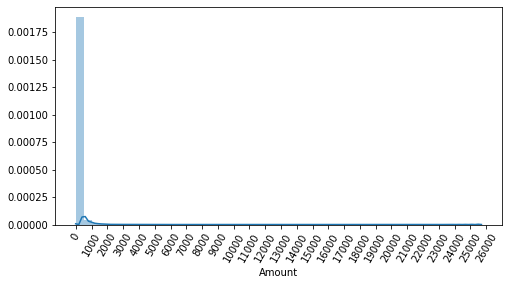

In [18]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

#### => 꼬리가 긴 형태의 쏠린 분포 곡선을 가짐. Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능 측정해보자.

In [30]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n) # df_copy의 0번째 칼럼 인덱스에 Amount_Scaled라는 새로운 칼럼에 amount_n 입력
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

#### => 함수 수정 후 get_train_test_dataset()을 호출해 학습/테스트 데이터 세트를 생성한 후 get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가하기

In [31]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df) # 학습/테스트 데이터 세트 생성
    # get_train_test_dataset에 get_preprocessed_df가 포함되있음.
    
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
    # get_model_train_eval() : 학습, 예측, 평가까지 모두 하는 함수
    
print('### LightGBM 예측 성능 ###')
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081
### LightGBM 예측 성능 ###
오차 행렬
[[85263    32]
 [  107    41]]
정확도: 0.9984, 정밀도: 0.5616, 재현율: 0.2770


#### => 정규분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지 않음.

#### 이번에는 StandardScaler가 아니라 로그 변환을 수행해보자. 
    로그변환은 데이터 분포도가 심하게 왜곡되어있을경우 적용하는 중요 기법 중 하나.
    원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해줌.


In [32]:
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n=np.log1p(df_copy['Amount']) # log1p() : 로그변환 함수
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [33]:
# Amount 피처를 로그변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인해보자.

In [34]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8824, 재현율: 0.6081
### LightGBM 예측 성능 ###
오차 행렬
[[85266    29]
 [   65    83]]
정확도: 0.9989, 정밀도: 0.7411, 재현율: 0.5608


#### => 두 모델 약간씩 성능이 개선되었지만 미비한 수준.

## 이상치 데이터 제거 후 모델 학습/예측/평가
+ 이상치 데이터(Outlier) : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불림.
+ IQR 방식 : 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯 방식으로 시각화 가능
+ 사분위 : 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%)씩으로 구간을 분할하는걸 지칭.
    IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 범위에 속하지 않는 데이터를 이상치로 간주하는 것. IQR 방식을 시각화한 도표가 박스 플롯.

#### 이제 이상치 데이터를 IQR을 이용해 제거해보자.
    먼저 어떤 피처의 이상치 데이터를 검출할 것인지 선택이 필요하다.
    매우 많은 피처가 있을 경우 이들 중 결정값(즉 레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다.

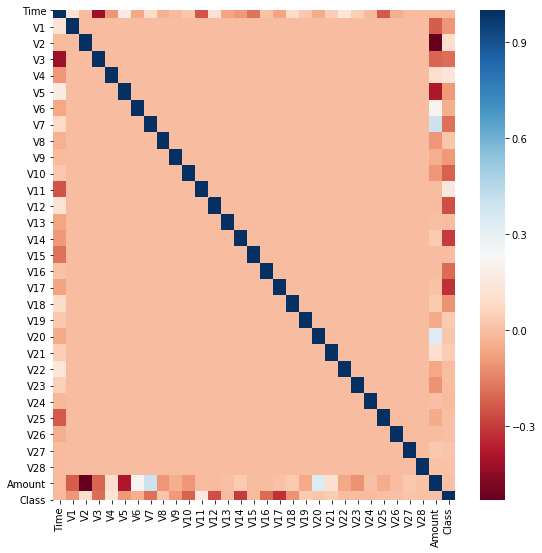

In [35]:
# 먼저 DataFrame의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap으로 시각화해보기.
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')

#### => 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17. 

In [36]:
# 먼저, IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제하자. V14만 먼저.

In [40]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함.
    fraud=df[df['Class']==1][column]
    quantile_25=np.percentile(fraud.values, 25) # 25% 지점
    quantile_75=np.percentile(fraud.values, 75) # 75% 지점
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr=quantile_75-quantile_25 # 3분위수 - 1분위수
    iqr_weight=iqr*weight
    lowest_val=quantile_25-iqr_weight # 최솟값 = 1분위수 - IQR*1.5
    highest_val=quantile_75+iqr_weight # 최댓값 = 3분위수 + IQR*1.5
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

In [38]:
# get_outlier() 함수를 이용해 V14 칼럼에서 이상치 데이터 찾아보기

In [41]:
outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


#### get_outlier()를 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터 가공한 뒤 이 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델 다시 적용하기.

In [44]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경.
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 이상치 데이터 제거하는 로직 추가
    outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [45]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85282    13]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8829, 재현율: 0.6712
### LightGBM 예측 성능 ###
오차 행렬
[[85233    62]
 [  110    36]]
정확도: 0.9980, 정밀도: 0.3673, 재현율: 0.2466


#### => 이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상됨.

## SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
    SMOTE를 적용할 땐 반드시 학습 데이터 세트만 오버 샘플링을 해야 함. 검증 데이터나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없음.

In [46]:
# 앞 예제에서 생성한 학습 피처/레이블 데이터를 SMOTE 객체의 fit_sample() 메서드를 이용해 증식한 뒤와 증식 전 데이터 비교.
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
dtype: int64


#### => SMOTE 오버 샘플링 적용 전 학습 데이터 세트가 2배에 가까운 398,040 건으로 데이터가 증식됨. 그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020건으로 생성됨.

In [47]:
# 이렇게 생성된 학습 데이터 세트를 기반으로 먼저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해보자.

In [49]:
lr_clf=LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, 
                      tgt_test=y_test)

오차 행렬
[[82932  2363]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0540, 재현율: 0.9247


#### => 로지스틱의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 크게 중가하지만, 반대로 정밀도가 5.4%로 급격하게 저하됨. 재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없음. 
    이는 로지스틱 회귀모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것. 분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인해보자.

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold값 X 축의 Scale을 0.1 단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

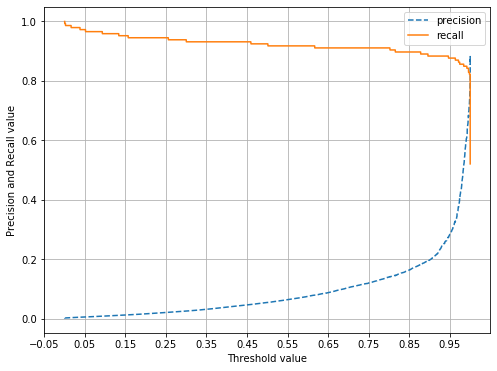

In [53]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

#### => 임계값 0.99 이하에선 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도도 높아짐. 
    분류 결정 임계깞을 조정하더라도 임계깞의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했음. 

In [54]:
# 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가 수행하자.

In [55]:
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, 
                     tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493


#### => 재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 되었지만 정밀도는 이전의 96.8%보다 낮은 93.94%임. 
    SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적임. 